In [1]:
#from __future__ import division, print_function, unicode_literals
import numpy as np
import torch
import torch.utils.data
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import torch.nn.functional as F
import os
from PIL import Image
import matplotlib.patches as patches
%matplotlib inline
plt.ion()
# Import other modules if required
# Can use other libraries as well

resnet_input = 224 #size of resnet18 input images

In [2]:
from torchvision import datasets, models, transforms

In [16]:
import math

In [7]:
def image_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [3]:
cd /mnt/data/cv3/

/mnt/data/cv3


In [251]:
model = torch.load('model_my.pth',map_location='cpu')

In [8]:
img = image_loader('/mnt/data/cv3/trainval/train/aeroplane/000032_1.jpg')

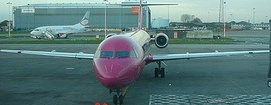

In [12]:
img

In [29]:
img.size

(271, 105)

In [19]:
og_scale = math.sqrt(img.size[0]*img.size[1])

In [20]:
my_s = og_scale*.5

In [27]:
1.75*math.sqrt((my_s**2)/1.75)

111.57536690506556

In [10]:
pic = np.array(img)

In [11]:
pic.shape

(105, 271, 3)

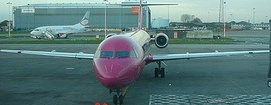

In [13]:
Image.fromarray(pic)

In [8]:
test = torch.randn(1,3,224,224)

In [36]:
#test
model(test)

tensor([[  3.8595,  14.5691, -19.2837,   3.7337]], grad_fn=<AddmmBackward>)

In [5]:
composed_transform = transforms.Compose([transforms.Resize((224,224)),
                                         transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),])

In [4]:
transform_pipeline = transforms.Compose([transforms.Resize((224, 224)),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                  std=[0.229, 0.224, 0.225])])

In [41]:
inp = composed_transform(img)
inp = inp.unsqueeze(0)

In [42]:
#tensor = tensor.type('torch.DoubleTensor')

with torch.no_grad():
    out = model1(inp)
    _, pred = torch.max(out,1)
    print(pred)

tensor([1])


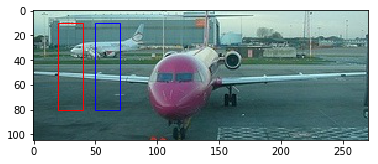

In [31]:
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(pic)

# Create a Rectangle patch
rect1 = patches.Rectangle((20,10),40-20,80-10,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((50,10),40-20,80-10,linewidth=1,edgecolor='b',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect1)
ax.add_patch(rect2)

plt.show()


In [6]:
def intersection_over_union(box1, box2):
    [x_min_1, y_min_1, x_max_1, y_max_1] = box1
    [x_min_2, y_min_2, x_max_2, y_max_2] = box2
    delta_x = min(x_max_1,x_max_2)-max(x_min_1,x_min_2)
    delta_y = min(y_max_1,y_max_2)-max(y_min_1,y_min_2)
    if(delta_x<=0 or delta_y<=0) : return 0
    area_1 = (x_max_1 - x_min_1) * (y_max_1 - y_min_1)
    area_2 = (x_max_2 - x_min_2) * (y_max_2 - y_min_2)
    and_area = delta_x*delta_y
    or_area = area_1+area_2-and_area
    return and_area/or_area
def non_maximum_supression(boxes,probability_threshold=0.1, threshold=0.3):
	# Assume the boxes are of this form [class, probability, x1, y1, x2, y2]
    # Index of object belongs to [0,1,2,3]
    boxes_for_all_objects=[]
    for class_index in range(4):
        if class_index==1 : continue
        boxes_for_an_object=[]
        for k in range(len(boxes)) : 
            if(boxes[k,0]==class_index) : boxes_for_an_object.append(boxes[k])
        if(len(boxes_for_an_object)==0) : continue
        boxes_for_an_object=np.array(boxes_for_an_object)
        #print(boxes_for_an_object.shape)
        just_boxes=[]
        for i in range(boxes_for_an_object.shape[0]): 
            just_boxes.append(boxes_for_an_object[i,2:])
        #boxes_for_an_object=np.array(boxes_for_an_object)
        probabilities = boxes_for_an_object[:,1]
        probabilities = probabilities[probabilities>=probability_threshold]
        object_indices = np.argsort(probabilities)
        object_indices = object_indices.tolist()
        boxes_after_nms=[]
        while(len(object_indices)>0):
            #print(len(object_indices))
            index=len(object_indices)-1
            box=just_boxes[object_indices[index]]
            box_with_class=np.concatenate((np.array([class_index]),box),0)
            del object_indices[index]
            boxes_after_nms.append(box_with_class)
            i=0
            while len(object_indices) and i < len(object_indices):
                if intersection_over_union(just_boxes[object_indices[i]],box)>threshold: 
                    del object_indices[i]
                    i-=1
                i+=1
        #print(len(boxes_after_nms))
        boxes_for_all_objects.append(boxes_after_nms)
    return np.array(boxes_for_all_objects)


def sliding_window(model, image_path, step_size, list_of_window_sizes):
    # import torch.nn.functional as F
    # from torch.autograd import Variable
    img=image_loader(image_path)
    # resize test image
    img = img.resize((224,224),Image.ANTIALIAS)
    #print(img.size)
    array=np.array(img)
    boxes=[]
    for window_size in list_of_window_sizes:
        for y in range(0,array.shape[0]-window_size[1],step_size):
            for x in range(0,array.shape[1]-window_size[0],step_size):
                slide_box = np.array([y,x,y+window_size[1],x+window_size[0]])
                partial_array = array[y:y+window_size[1],x:x+window_size[0],:]
                partial_image=Image.fromarray(partial_array)
                partial_image = transform_pipeline(partial_image)
                partial_image = partial_image.unsqueeze(0)
                partial_image = Variable(partial_image)
                # slide_box = [p_aero, p_back, p_bottle, p_chair, x1, y1, x2, y2]
                with torch.no_grad():
                    output=model(partial_image).squeeze(0)
                output=output.view(1,output.shape[0])
                output=np.array(F.softmax(Variable(output), dim=1).data)
                output=output.reshape(output.shape[1])
                #print(output.shape, end = " ")
                #print(slide_box.shape)
                arg_max=np.array([np.argmax(output)])
                val_max=np.array([np.max(output)])
                if arg_max==0 : continue
                arg_val=np.concatenate((arg_max, val_max),0)
                slide_box = np.concatenate((arg_val,slide_box),axis=0)
                boxes.append(slide_box)
    return np.array(boxes)

In [385]:
## Bounding boxes
step_size=30
list_of_window_sizes = [[100,100], [150,150]]
image_path='/mnt/data/cv3/trainval/train/aeroplane/000032_1.jpg'
boxes=sliding_window(model,image_path,step_size,list_of_window_sizes)
boxes_for_all_objects=non_maximum_supression(boxes,probability_threshold = 0.8,threshold=0.01)

0.9999035596847534
0.9996843338012695
0.981609582901001


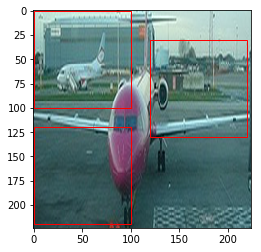

In [388]:
fig,ax = plt.subplots(1)
ax.imshow(pic)
for box in boxes_for_all_objects:
    box = box[1:]
    if box[2]-box[0]==100:
        c = 'r'
    else: c = 'b'
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=1,edgecolor=c,facecolor='none')
    ax.add_patch(rect)
plt.show()

In [387]:
boxes_for_all_objects

[array([  1., 120.,  30., 220., 130.]),
 array([  1.,   0.,   0., 100., 100.]),
 array([  1.,   0., 120., 100., 220.])]